# Sampling without replacement
This notebook implements different algorithms for sampling without replacement from directed acyclic graphical models (Bayesian networks), especially *ancestral Gumbel-Top-$k$ sampling*, and explores their efficiency on randomly generated Bayesian networks.

In [1]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os

In [2]:
from torch.distributions import Gumbel

def gumbel_with_maximum(phi, T, dim=-1):
    """
    Samples a set of gumbels which are conditioned on having a maximum along a dimension
    phi.max(dim)[0] should be broadcastable with the desired maximum T
    """
    # Gumbel with location phi, use PyTorch distributions so you cannot get -inf or inf (which causes trouble)
    g_phi = Gumbel(phi, torch.ones_like(phi)).rsample()
    Z, argmax = g_phi.max(dim)
    g = _shift_gumbel_maximum(g_phi, T, dim, Z=Z)
    return g, argmax


def shift_gumbel_maximum(g_phi, T, dim=-1, Z=None):
    g = _shift_gumbel_maximum(g_phi, T, dim, Z)
    CHECK_VALIDITY = True
    if CHECK_VALIDITY:
        g_inv = _shift_gumbel_maximum(g, Z, dim)
        if not (((g_phi - g_inv) < 1e-3) | (g_phi == g_inv)).all():
            # Disabled, in some cases we simply loose accuracy since we store absolute gumbel values instead of
            # the difference to their maximum which is closer to 0 and thus more stable
            RAISE_INVALID = False
            if RAISE_INVALID:
                assert False
        # assert (((g_phi - g_inv) < 1e-3) | (g_phi == g_inv)).all()
    return g


def _shift_gumbel_maximum(g_phi, T, dim=-1, Z=None):
    if Z is None:
        Z, _ = g_phi.max(dim)
    u = T.unsqueeze(dim) - g_phi + torch.log1p(-torch.exp(g_phi - Z.unsqueeze(dim)))
    return T.unsqueeze(dim) - F.relu(u) - torch.log1p(torch.exp(-u.abs()))



In [3]:
def binary2long(m): # converts binary to long
    return (m.long() << torch.arange(m.size(-1), out=m.new().long())).sum(-1)

def generate_graph(num_nodes=10, connectivity=1.0):

    # This gives for each node its predecessors
    graph = torch.tril(torch.rand(num_nodes, num_nodes) < connectivity, -1)
    # For each node, a random variable how much it is influenced by (all) of its predecessors (uniform 0-1)
    alpha = torch.rand(num_nodes)
    # Prior distribution for each node
    prior = torch.rand(num_nodes)
    # Conditional distributions
    # There are 2 ^ num_nodes possible configurations (each variable is 0 or 1)
    domain_size = 2 ** num_nodes
    # For each node, define the probability that it is positive
    # depending on the configuration of the previous nodes
    # This takes into account the prior probability 
    # and the probability depending on the configurations of privious nodes with weight alpha
    model = torch.rand(num_nodes, domain_size) * alpha[:, None] + (prior * (1 - alpha))[:, None]
    
    return model, graph

# Ancestral Gumbel-Top-$k$ sampling

In [4]:
def get_model_logprobs(model, v, y):
    ylong = mask2long(y)[0]  # Bit ugly, does not return a scalar
    prob_true = model[v, mask2long(y)[0]]
    logprobs = torch.log(torch.tensor([prob_true]))

def binary_entropy(p):
    # Compute the binary entropy https://en.wikipedia.org/wiki/Binary_entropy_function
    return -(p * torch.log2(p) + (1 - p) * torch.log2(1 - p))
    
def strategy_fixed(vs, model, graph, y):
    return vs[0]

def strategy_random(vs, model, graph, y):
    return vs[random.randrange(len(vs))]

def strategy_entropy(vs, model, graph, y, lowest=True):
    entropy = binary_entropy(model[vs, binary2long(y[None, :] * graph[vs])])
    _, ind = torch.min(entropy, -1) if lowest else torch.max(entropy, -1)
    return vs[ind]
        
def gumbel_top_k_sampling(model, graph, k, m=1, strategy=None):
    if strategy is None:
        strategy = strategy_fixed
    # Model gives probability of 1
    log_probs = torch.stack([1 - model, model], -1).log()
    queue = [(
        torch.zeros(graph.size(-1), dtype=torch.uint8), # S
        torch.zeros(graph.size(-1), dtype=torch.uint8), # y
        torch.tensor(0.), # phi
        torch.tensor(0.) # G_phi
    )]
    iterations = 0
    while (len(queue) > 0):
        expand, queue = queue[:m], queue[m:]
        for (S, y, phi, G_phi) in expand:  # This can be done in parallel
            if S.all(): # Boolean mask, check if all variables sampled
                # Put back on the queue
                queue.append((S, y, phi, G_phi))
                continue
                
            # Feasible nodes to expand (either 0 = no dependency or 1 <= s_i
            # which means the parent has been sampled), also not sampled already
            ready_for_sampling = (graph <= S[None, :]).all(-1) & (S == 0)
            vs = torch.nonzero(ready_for_sampling).view(-1)
            v = strategy(vs, model, graph, y)  # Variable selection strategy
            
            S_prime = S.clone()
            S_prime[v] = True  # Done
            
            # By multiplying y with graph[v], we set y to 0 for all parents on which
            # there is no dependency, such that we only look up different probabilities
            # if the values on which there is a dependency differ
            conditional_config_index = binary2long(y * graph[v])
            log_p_y_cond = log_probs[v, conditional_config_index]
            phi_prime = log_p_y_cond + phi
            # Sample the gumbels conditionally
            G_phi_prime, _ = gumbel_with_maximum(phi_prime, G_phi)
            
            for (y_v, (phi_prime_, G_phi_prime_)) in enumerate(zip(phi_prime, G_phi_prime)):
                y_prime_ = y.clone()
                y_prime_[v] = y_v
                
                queue.append((S_prime, y_prime_, phi_prime_, G_phi_prime_))
        # print(queue)
        queue = sorted(queue, key=lambda tpl: -tpl[-1])[:k]  # Sort descending on perturbed log-probability and take topk
        iterations = iterations + 1
        
        # Now yield
        while len(queue) > 0 and queue[0][0].all():
            (S, y, phi, G_phi) = queue.pop(0)  # Remove first element of list
            yield y, G_phi, iterations
            k = k - 1  # Remaining number of samples

# Rejection sampling

In [5]:
def ancestral_sampling_with_replacement(model, graph, m=1):
    iterations = 0
    while True:
        batch = []
        for i in range(m):  # 'in parallel'
            y = torch.zeros(graph.size(-1), dtype=torch.uint8)
            for v, model_v in enumerate(model):
                conditional_config_index = binary2long(y * graph[v])
                p_cond = model_v[conditional_config_index]
                # p_cond is probability of 1
                y[v] = 1 if random.uniform(0, 1) < p_cond else 0
            batch.append(y)
        iterations += model.size(0)
        yield batch, iterations
    
def rejection_sampling_without_replacement(model, graph, k, m=1):
    # It is feasible to just keep a boolean for each element in the domain
    sampled = torch.zeros(model.size(1), dtype=torch.uint8)
    for (batch, iterations) in ancestral_sampling_with_replacement(model, graph, m):
        for y in batch:
            y_long = binary2long(y)
            if sampled[y_long]:
                continue # Reject
            sampled[y_long] = True
            k = k - 1
            # Return 0 as perturbed log-prob, does not matter
            yield y, torch.tensor(0.), iterations
            if k == 0:
                return

# Naive ancestral sampling without replacement

In [6]:
class Node:
    
    def __init__(self, y=None, p=1., parent=None):
        # self.v = v  # Variable that determines split for children
        self.y = y  # Value of parent! variable for this branch
        assert p > 0
        self.p = p  # Joint!!! Probability of this node (sum of probabilities of all nodes in subtree)
        self.parent = parent
        self.children = None
        
    def expand(self, v, probs):
        assert np.allclose(sum(probs), 1.)
        self.v = v
        # Multiply so children divide the probability mass of this node
        self.children = [Node(i, p * self.p, self) for i, p in enumerate(probs)]
    
    def sample_child(self):
        assert self.children is not None
        assert self.p > 0
        probs = [c.p / self.p for c in self.children]
        # This should hold as sum of p for children should be self.p
        if not np.all(np.array(probs) >= 0):
            print(probs)
        assert np.all(np.array(probs) >= 0)
        assert np.allclose(sum(probs), 1.)
        # Torch multinomial can sample with unnormalized probs 
        # (but we have normalized them here)
        # probs for already sampled children is 0
        return self.children[torch.multinomial(torch.tensor(probs), 1).item()]
        
    def backup(self, p):
        if self.p == 0:
            return  # Would have no effect anyway
        self.p = self.p - p
        if self.p < 0: # Fix for numeric instability
            assert self.p > -1e-5
            self.p = 0
        assert self.p >= 0
        if self.parent is not None:
            self.parent.backup(p)
            

def naive_ancestral_sampling_without_replacement(model, graph, k, m=1):
    iterations = 0
    root = Node()
    
    sampled = torch.zeros(model.size(1), dtype=torch.uint8)
    while True:
        batch = list()
        for i in range(m):  # 'in parallel' generate m candidates
            y = torch.zeros(graph.size(-1), dtype=torch.uint8)
            node = root
            for v, model_v in enumerate(model):
                
                conditional_config_index = binary2long(y * graph[v])
                p_cond = model_v[conditional_config_index]
                if node.children is None:  
                    # This is not entirely parallelizable but does not really matter
                    # since we do not update nodes yet and we could also build the tree later
                    # p_cond is probability of 1
                    node.expand(v, [1 - p_cond, p_cond])
                node = node.sample_child()
                y[v] = node.y
            
            batch.append((node, y))  # This will directly remove duplicates
        nodes, ys = zip(*batch)
        for node in nodes:
            # Will backup all the way in the tree
            # does not matter if it does twice for duplicates (second time will have no effect)
            node.backup(node.p)  
        iterations += model.size(0)
        
        for y in ys: # Now yield the unique onces of these!
            
            y_long = binary2long(y)
            if sampled[y_long]:
                continue # Reject
            sampled[y_long] = True
            k = k - 1
            yield y, torch.tensor(0.), iterations
            if k == 0:
                return


# Experiments

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from functools import partial

k = 100

methods = [
    (gumbel_top_k_sampling, 'Gumbel', '-'),
    (rejection_sampling_without_replacement, 'Rejection', ':'),
    (naive_ancestral_sampling_without_replacement, 'Naive', '--'),
]

methods_variable_selection = [
    (partial(gumbel_top_k_sampling, strategy=strategy_fixed), 'Fixed', '-'),
    (partial(gumbel_top_k_sampling, strategy=strategy_random), 'Random', '-'),
    (partial(gumbel_top_k_sampling, strategy=partial(strategy_entropy, lowest=True)), 'Min entropy', '-'),
    (partial(gumbel_top_k_sampling, strategy=partial(strategy_entropy, lowest=False)), 'Max entropy', '-'),
]

all_results = []

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ms = (1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

def gather_output(result):
    samples, G_phi, iterations = zip(*result)
    G_phi = torch.stack(G_phi, -1)
    assert (G_phi[1:] <= G_phi[:-1]).all(), "Samples should be generated in nonincreasing order"
    return iterations

connectivity_vals = np.linspace(0, 1, 11)
default_connectivity = 0.5
repetitions = 100

all_models = {
    c: [generate_graph(connectivity=c) for i in range(repetitions)]
    for c in connectivity_vals
}
assert default_connectivity in all_models

results_methods_parallelism = np.array(
    [
        [
            [
                gather_output(method(model, graph, k, m)) 
                for model, graph in all_models[default_connectivity]
            ]
            for m in ms
        ]
        for method, _, _ in tqdm(methods)
    ]
)

results_strategy_connectivity = np.array(
    [
        [
            [
                gather_output(method(model, graph, k, m=1)) 
                for model, graph in connectivity_models
            ]
            for connectivity, connectivity_models in all_models.items()
        ]
        for method, _, _ in tqdm(methods_variable_selection)
    ]
)

100%|██████████| 4/4 [21:59<00:00, 331.76s/it]


# Results
Set `SAVE_FIGURES = True` to save the plots to PDF files.

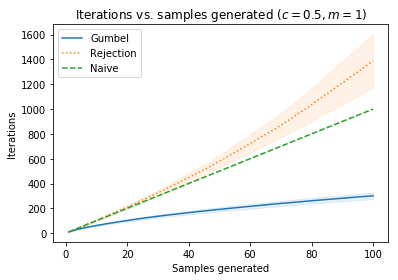

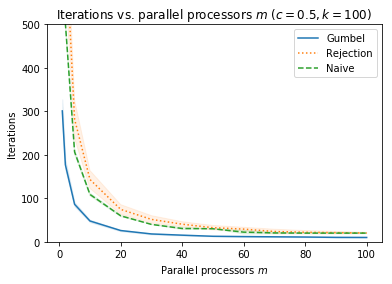

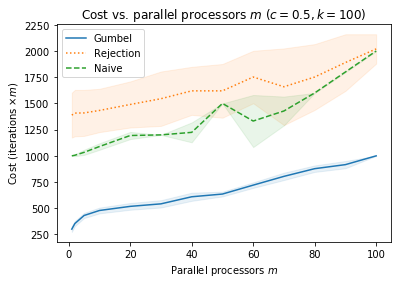

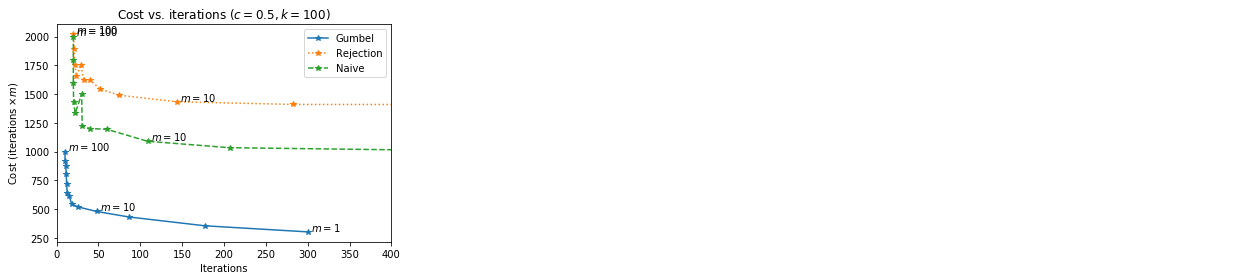

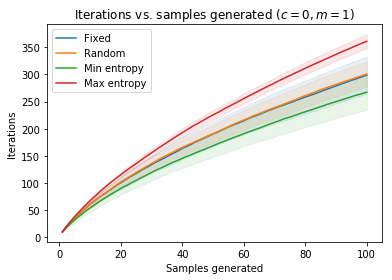

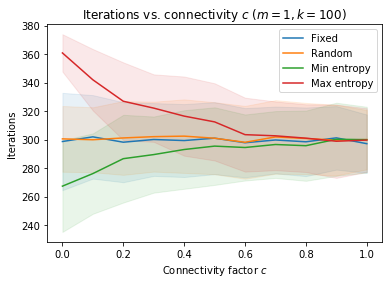

In [16]:
SAVE_FIGURES = True

plotsdir = 'plots'
if SAVE_FIGURES:
    os.makedirs(plotsdir, exist_ok=True)

def plot_results(xvals, methods, results):
    for j, ((method, name, linestyle), iterations_all) in enumerate(zip(methods, results)):
        # iterations = [repetitions x num_samples]
        iterations_mean = iterations_all.mean(0)
        # iterations_min, iterations_max = iterations_all.min(0), iterations_all.max(0)
        iterations_std = iterations_all.std(0)
        iterations_min, iterations_max = iterations_mean - iterations_std, iterations_mean + iterations_std
        c = colors[j]

        plt.plot(xvals, iterations_mean, label=name, color=c, linestyle=linestyle)
        plt.fill_between(xvals, iterations_min, iterations_max, color=c, alpha=0.1)
        
# Plot results for m = 1 as a function of number of samples
num_samples = np.arange(k) + 1
plot_results(num_samples, methods, results_methods_parallelism[:, 0])

plt.title('Iterations vs. samples generated ($c = 0.5, m = 1$)')
plt.xlabel('Samples generated')
plt.ylabel('Iterations')
plt.legend()

if SAVE_FIGURES:
    plt.savefig(os.path.join(plotsdir, 'methods_its_vs_samples.pdf'), fmt='pdf')
plt.show()

# Take results for end of each experiment (total iterations to generate k samples) for each m
iterations_methods_different_m = results_methods_parallelism[..., -1].swapaxes(-1, -2)
plot_results(ms, methods, iterations_methods_different_m)
        
plt.title(f"Iterations vs. parallel processors $m$ ($c = 0.5, k = {k}$)")
plt.xlabel('Parallel processors $m$')
plt.ylabel('Iterations')
plt.ylim([0, 500])
plt.legend()

if SAVE_FIGURES:
    plt.savefig(os.path.join(plotsdir, 'methods_its_vs_parallel.pdf'), fmt='pdf')
plt.show()

# Take results for end of each experiment (total iterations to generate k samples) for each m
# Multiply them by m to get total cost
cost_methods_different_m = iterations_methods_different_m * np.array(ms)[None, None, :]
plot_results(ms, methods, cost_methods_different_m)

plt.title(f"Cost vs. parallel processors $m$ ($c = 0.5, k = {k}$)")
plt.xlabel('Parallel processors $m$')
plt.ylabel('Cost (iterations $\\times m$)')
plt.legend()

if SAVE_FIGURES:
    plt.savefig(os.path.join(plotsdir, 'methods_cost_vs_parallel.pdf'), fmt='pdf')
plt.show()


# Special code for 'scatter plot'
for j, ((method, name, linestyle), iterations_all, cost_all) in enumerate(zip(methods, iterations_methods_different_m, cost_methods_different_m)):
    iterations_mean = iterations_all.mean(0)
    cost_mean = cost_all.mean(0)
    
    c = colors[j]
    plt.plot(iterations_mean, cost_mean, label=name, color=c, linestyle=linestyle, marker='*')
    
    for m, it, cst in zip(ms, iterations_mean, cost_mean):
        if m not in (1, 10, 100):
            continue
        plt.annotate(f"$m = {m}$", (it, cst), xytext=(3, 1),  # 3 points vertical offset
                    textcoords="offset points")
    
plt.title(f"Cost vs. iterations ($c = 0.5, k = {k}$)")
plt.xlabel('Iterations')
plt.ylabel('Cost (iterations $\\times m$)')
plt.xlim([0, 400])
plt.legend()

if SAVE_FIGURES:
    plt.savefig(os.path.join(plotsdir, 'methods_cost_vs_its.pdf'), fmt='pdf')
plt.show()




############## Results for different levels of connectivity and different variable selection strategies

# Plot results for m = 1 as a function of number of samples
num_samples = np.arange(k) + 1
plot_results(num_samples, methods_variable_selection, results_strategy_connectivity[:, 0])
        
plt.title('Iterations vs. samples generated ($c = 0, m = 1$)')
plt.xlabel('Samples generated')
plt.ylabel('Iterations')
plt.legend()

if SAVE_FIGURES:
    plt.savefig(os.path.join(plotsdir, 'strategy_its_vs_samples.pdf'), fmt='pdf')
plt.show()

# Take results for end of each experiment (total iterations to generate k samples) for each level of connectivity
plot_results(connectivity_vals, methods_variable_selection, results_strategy_connectivity[..., -1].swapaxes(-1, -2))

plt.title(f"Iterations vs. connectivity $c$ ($m = 1, k = {k}$)")
plt.xlabel('Connectivity factor $c$')
plt.ylabel('Iterations')
plt.legend()

if SAVE_FIGURES:
    plt.savefig(os.path.join(plotsdir, 'strategy_its_vs_conn.pdf'), fmt='pdf')
plt.show()